In [93]:
import numpy as np
import ten
import ipywidgets as widgets
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ["svg"]
import itertools
from tqdm.auto import tqdm



$$ m_i = \begin{pmatrix}
1 \\ -1
\end{pmatrix}
$$

In [2]:
temperature = widgets.FloatSlider(min=2, max=5)
temperature

FloatSlider(value=2.0, max=5.0, min=2.0)

In [3]:
D = widgets.IntSlider(value=8, min=8, max=24)
D

IntSlider(value=8, max=24, min=8)

In [4]:
steps = widgets.IntSlider(min=4, max=100)
steps

IntSlider(value=4, min=4)

In [42]:
tol = widgets.FloatLogSlider(value=1e-6, base=10, min=-15, max=-3, step=1)
tol

FloatLogSlider(value=1e-07, max=-3.0, min=-15.0, step=1.0)

In [5]:
def trace(t):
	return np.einsum("iijj->", t)

$$ Z = \sum_{i} e^{- \beta E_i} = \text{Tr} \prod_i T_{l_i r_i u_i d_i} $$

$$ T^{(0)}_{lrud} = \sum_\alpha W_{\alpha,l} ~ W_{\alpha,r} ~ W_{\alpha,u} ~ W_{\alpha,d}$$

$$ W_{ij} = \begin{pmatrix}
\sqrt{\cosh\left(\frac{1}{t}\right)} & \sqrt{\sinh\left(\frac{1}{t}\right)} \\
\sqrt{\cosh\left(\frac{1}{t}\right)} & -\sqrt{\sinh\left(\frac{1}{t}\right)}
\end{pmatrix}
$$

$$ H^{(0)}_{lrud} = \sum_\alpha W_{\alpha,l} ~ W_{\alpha,r} ~ W_{\alpha,u} ~ W_{\alpha,d} ~ m_\alpha ~~~~ \text{where} ~~~~ m_\alpha = \begin{pmatrix} 1 \\ -1 \end{pmatrix} $$

$$ \text{Magnetization} = \frac{\text{Tr}(H)}{\text{Tr}(Z)} $$


$$ M^{(n)}_{lrud} = \sum_\alpha T^{(n-1)}_{l_1 r_1 u \alpha} T^{(n-1)}_{l_2 r_2 \alpha d} ~~~~ \text{where} ~~~~ l = l_1 \otimes l_2, ~~ r = r_1 \otimes r_2 $$

In [6]:
def M(u: np.ndarray, d: np.ndarray) -> np.ndarray:
	t = np.einsum("abci,deif->adbecf", u, d)
	return t.reshape((t.shape[0]*t.shape[1], t.shape[2]*t.shape[3], t.shape[4], t.shape[5]))


$$ M^{(n)}_{lrud} = \sum_{\alpha \beta \gamma \epsilon} S_{\alpha \beta \gamma \epsilon} U^L_{l,\alpha} U^R_{r,\beta} U^U_{u,\gamma} U^D_{d,\epsilon} $$

$$ \varepsilon_1 = \sum_{i > D} \vert S_{i,:,:,:} \vert^2, ~~~~ \varepsilon_2 = \sum_{j > D} \vert S_{:,j,:,:} \vert^2 $$

$$ \hat{U} = \begin{cases}
U^L, & \varepsilon_1 < \varepsilon_2 \\
U^R, & \text{otherwise}
\end{cases}
$$

$$ T^{(n)}_{lrud} = \sum_{\alpha \beta} \hat{U}_{l,\alpha} M^{(n)}_{\alpha \beta u d} \hat{U}_{r,\beta} $$

In [59]:
def one_iteration(H: np.ndarray, T: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
	# contract with environment
	Mt = M(T, T)
	Mh = M(H, T)

	# decompose tensor
	S, Us = ten.hosvd(Mt)

	eps1 = sum(np.sum(np.square(np.abs(S[i,:]))) for i in range(D.value, S.shape[0]))
	eps2 = sum(np.sum(np.square(np.abs(S[:,j,:]))) for j in range(D.value, S.shape[1]))
	U = Us[0 if eps1 < eps2 else 1]

	# truncate U
	if U.shape[1] > D.value:
		U = U[:, 0:D.value]
	U = U / np.sqrt(np.max(S))

	# new T, H
	T = np.einsum("il,ijud,jr->lrud", U, Mt, U)
	H = np.einsum("il,ijud,jr->lrud", U, Mh, U)

	return H, T

magnetization[-1]=0.0
n=0 -> magnetization[-1]=-1.63398686900544e-16, ratio=-0.0
n=1 -> magnetization[-1]=-5.770841919547646e-16, ratio=0.2831453177517505
n=2 -> magnetization[-1]=-8.598726091638892e-16, ratio=0.6711275435507843
n=3 -> magnetization[-1]=-8.569958844909522e-16, ratio=1.0033567543613653
n=4 -> magnetization[-1]=-8.569959827219774e-16, ratio=0.9999998853774963


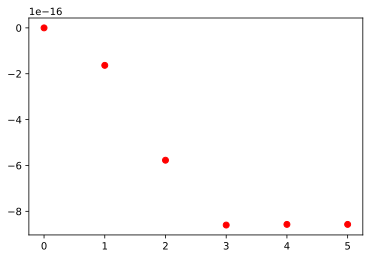

In [83]:
fig = plt.figure()
ax = fig.subplots(1)

T = ten.ising.partition_tensor(temperature.value)
H = ten.ising.magnetization(temperature.value)
magnetization = [trace(H)/trace(T)]

print(f"{magnetization[-1]=}")
ax.plot(0, magnetization[-1], "ro")

for n in range(steps.value):
	for permutator in itertools.islice(itertools.cycle([(0,1,3,2), (2,3,0,1)]), 4):
		H, T = one_iteration(H, T)
		H = H.transpose(permutator)
		T = T.transpose(permutator)

	magnetization.append(trace(H)/trace(T))
	ratio = magnetization[-2] / magnetization[-1]

	ax.plot(n+1, magnetization[-1], "ro")
	print(f"{n=} -> {magnetization[-1]=}, {ratio=}")

	if 1 - tol.value < ratio < 1 + tol.value:
		break

# stopping criterias

stop if ratio near 1

$$ \frac{\braket{m}^{(n-1)}}{\braket{m}^{(n)}} = 1 \pm tol ~~~~ \rightarrow ~~~~ \braket{m}^{(n-1)} = \braket{m}^{(n)} \pm tol [\%] $$

Text(0.5, 0, 'Iterations')

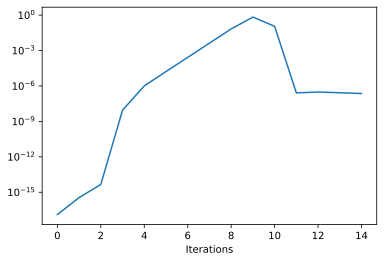

In [70]:
magnetization_diff = np.diff(np.abs(magnetization), n=1)
plt.semilogy(magnetization_diff)
plt.xlabel("Iterations")

Text(0.5, 0, 'Iterations')

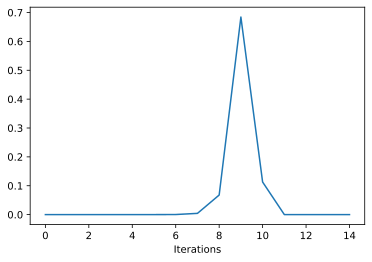

In [71]:
plt.plot(magnetization_diff)
plt.xlabel("Iterations")

/var/folders/89/8mn9ypb56tdgxpnrky2fmghh0000gn/T/ipykernel_7985/1706865808.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = [np.abs(a/b) for a,b in zip(magnetization[1:], magnetization)]


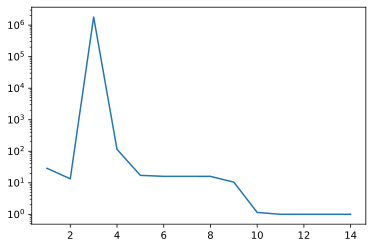

In [78]:
ratio = [np.abs(a/b) for a,b in zip(magnetization[1:], magnetization)]
plt.semilogy(ratio)

# magnetization vs temperature

In [101]:
Mz = {}

for temperature in tqdm(np.linspace(2, 3, (3-2)*10+1)):
	T = ten.ising.partition_tensor(temperature)
	H = ten.ising.magnetization(temperature)
	magnetization = [trace(H)/trace(T)]

	for n in tqdm(range(steps.value), leave=False):
		for permutator in itertools.islice(itertools.cycle([(0,1,3,2), (2,3,0,1)]), 4):
			H, T = one_iteration(H, T)
			H = H.transpose(permutator)
			T = T.transpose(permutator)

		magnetization.append(trace(H)/trace(T))
		ratio = magnetization[-2] / magnetization[-1]

		ax.plot(n+1, magnetization[-1], "ro")
		# print(f"{n=} -> {magnetization[-1]=}, {ratio=}")

		if 1 - tol.value < ratio < 1 + tol.value:
			break

	Mz[temperature] = magnetization[-1]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Magnetization')

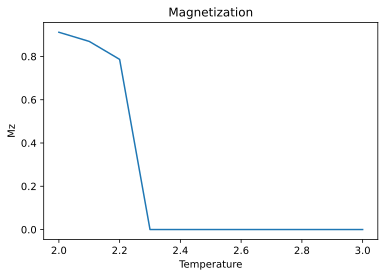

In [103]:
plt.plot(Mz.keys(), [np.abs(i) for i in Mz.values()])
plt.xlabel("Temperature")
plt.ylabel("Mz")
plt.title("Magnetization")